In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')
from collections import Counter
import json
import folium
import branca.colormap as cm

In [2]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [4]:
pnns1_clean_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(pnns1_clean_map)

Now the categories are clear:

In [5]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Dairies               17948
Composite             14670
Starchy               14612
Fish Meat Eggs        13993
Fruits Vegetables     12632
Beverages             12411
Fat Sauces            11427
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [6]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [7]:
category_map = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Dairies',
    'Meats' : 'Fish Meat Eggs',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs'
}

In [8]:
not_in_category = data[data['Category'].isna()]
keys = category_map.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [9]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(category_map)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [10]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Beverages             18255
Dairies               17948
Composite             14686
Starchy               14612
Fish Meat Eggs        14073
Fruits Vegetables     12632
Fat Sauces            11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [11]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [12]:
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Fruits Vegetables')
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Starchy')

In [13]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [14]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
beverages = data.query('Category == "Beverages"')

#### Compute points A

In [16]:
# energy
energy_bins = [data['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

# fat
fat_bins = [data['fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

# sugar
sugar_bins = [data['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

# sodium
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

#### Compute points C

In [17]:
# fruits-vegetables-nuts
fvn_bins = [data['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)
data['fvn_points'].fillna(0, inplace=True)

# fiber
fiber_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

# proteins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data['proteins_points'].fillna(0, inplace=True)

data['points_C'] = (data['fvn_points'] + data['fiber_points'] + data['proteins_points'])

Note that we made a concession on the missing data here: for each of the required column where the value is missing for the computation of points C, we attribute the value 0 to the corresponding points. The `fruits-vegetables-nuts_100g` columns was poorly represented, Thus this adaptation allows us to compute the nutri-score of a lot more products. Since the points C only reduces the final nutri-score (increase the healthiness rating), the result might just give a pessimistic view of the product, we still capture all the vicious traits from the points A.

#### Compute nutri-score

We first compute the nutri-score based on the formula mentioned [ahead](#Nutri-Score-Computation).

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['nutri-score'] = data.apply(compute_score, axis=1)

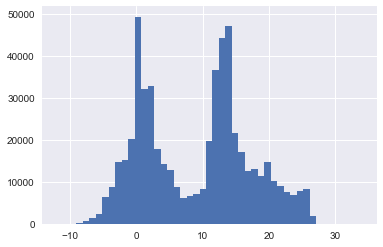

In [20]:
data['nutri-score'].hist(bins=int(data['nutri-score'].max() - data['nutri-score'].min() + 1));

Let's compare with the already present nutrition-score:

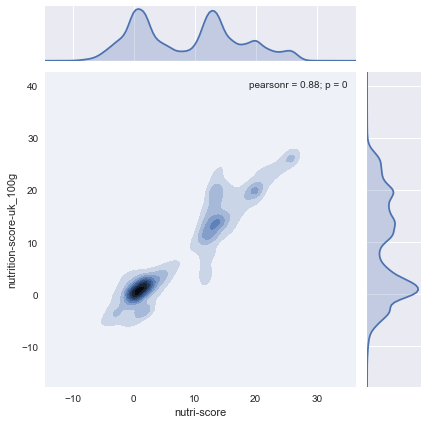

In [21]:
sns.jointplot('nutri-score', 'nutrition-score-uk_100g', data, kind='kde');

The correlation is decent, only around the value 12 our results distribution is too narrow but otherwise the relation seems good.

Now we assign the letter corresponding to the nutri-score.

In [22]:
def nutri_score_letter(row):
    nutri_score = row['nutri-score']
    product_name = row['product_name']
    
    # check if nutri_score is nan
    if nutri_score != nutri_score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if nutri_score <= 1:
            return 'B'
        elif nutri_score <= 5:
            return 'C'
        elif nutri_score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if nutri_score <= -1:
            return 'A'
        elif nutri_score <= 2:
            return 'B'
        elif nutri_score <= 10:
            return 'C'
        elif nutri_score <= 18:
            return 'D'
        else:
            return 'E'

In [23]:
data['nutri-score_letter'] = data.apply(nutri_score_letter, axis=1)

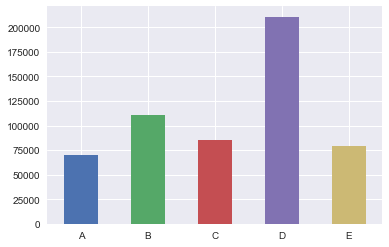

In [24]:
data['nutri-score_letter'].value_counts().sort_index().plot.bar(rot=0)

### Analyse the nutri-score across the categories

Let’s take a look at the percentage of grades for different food categories.

In [25]:
# Count the letter occurences for each category
letter_counts_per_cat = data.groupby(['Category', 'nutri-score_letter']).count()[['nutri-score']]
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         B                          5318
                  C                          4425
                  D                            83
                  E                          1760
Composite         A                          2250
                  B                          3342
                  C                          4271
                  D                          3705
                  E                            12
Dairies           A                          1051
                  B                          2742
                  C                          4305
                  D                          7547
                  E                           346
Fat Sauces        A                           374
                  B                           979
                  C                          1967
                  D                          3322
                  E                          3283
Fish Meat Eggs    A                          2806
                  B                           871
                  C                           979
                  D                          6909
                  E                            33
Fruits Vegetables A                          3480
                  B                          3267
                  C                          1544
                  D                           793
                  E                           144
Snacks            A                           196
                  B                           646
                  C                          1824
                  D                         14996
                  E                         14889
Starchy           A                          5014
                  B                          2923
                  C                          2201
                  D                          2440
                  E                           168
Unknown           A                         14201
                  B                         22689
                  C                         17242
                  D                         38819
                  E                         12484

In [26]:
# For some categories, some letters are not represented. We add the missing rows with 0 as value.
for cat in letter_counts_per_cat.index.levels[0]:
    for letter in letter_counts_per_cat.index.levels[1]:
        if (cat, letter) not in letter_counts_per_cat.index:
            letter_counts_per_cat.loc[(cat, letter), :] = 0
            
letter_counts_per_cat.sort_index(inplace=True)

In [27]:
# normalize the counts
totals = letter_counts_per_cat.reset_index()[['Category', 'nutri-score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

In [28]:
# colors similar to the original nutri-score ones
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

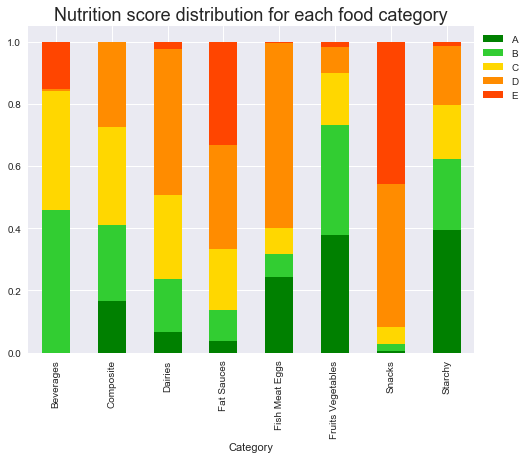

In [29]:
score_distr_per_cat.drop('Unknown').reset_index().pivot(index='Category', columns='nutri-score_letter', values='nutri-score').plot.bar(stacked=True, figsize=(8,6), color=nutri_score_colors)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

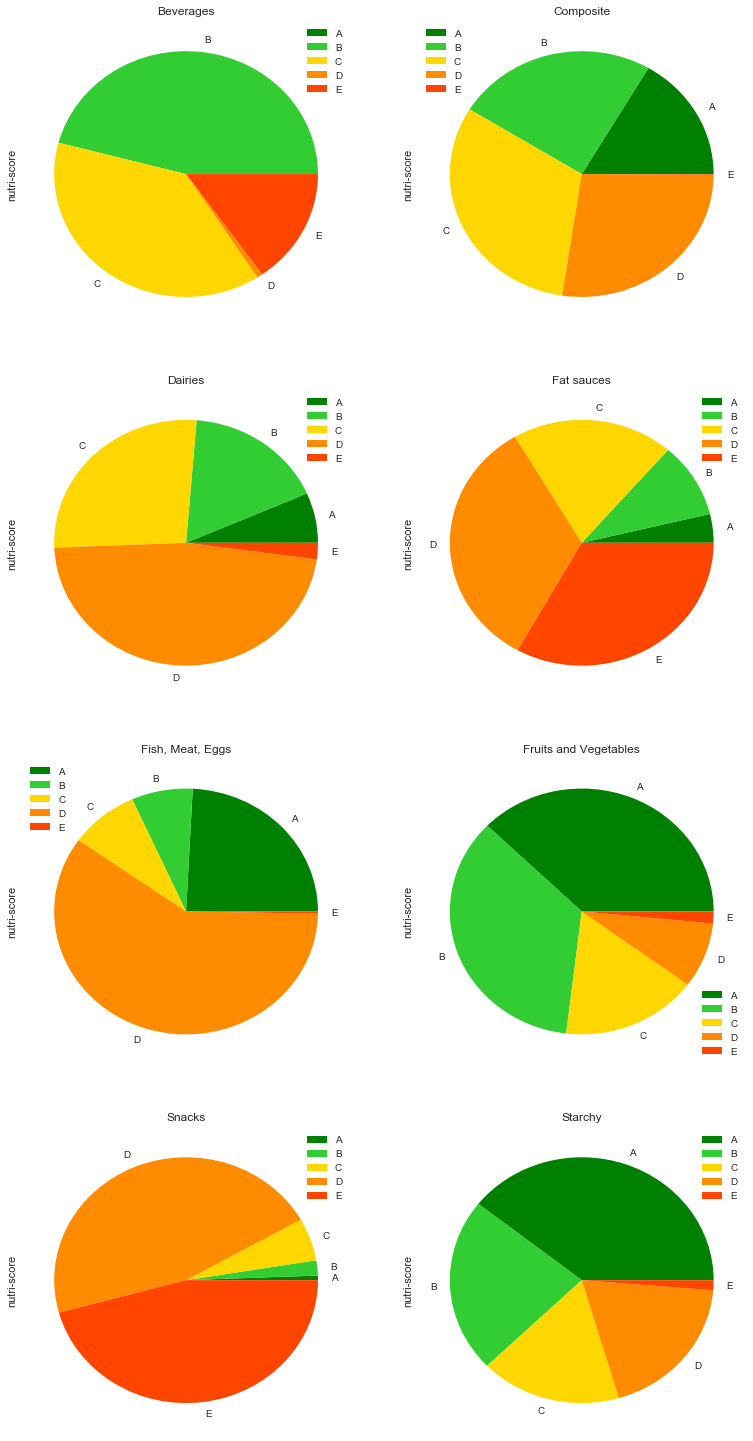

In [30]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('nutri-score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('nutri-score', ax=plt.subplot(422), title='Composite', colors=nutri_score_colors)
letter_counts_per_cat.loc['Dairies'].plot.pie('nutri-score', ax=plt.subplot(423), title='Dairies', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('nutri-score', ax=plt.subplot(424), title='Fat sauces', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs'].plot.pie('nutri-score', ax=plt.subplot(425), title='Fish, Meat, Eggs', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('nutri-score', ax=plt.subplot(426), title='Fruits and Vegetables', colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('nutri-score', ax=plt.subplot(427), title='Snacks', colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('nutri-score', ax=plt.subplot(428), title='Starchy', colors=nutri_score_colors);

We hear everywhere that fruits and vegetables are healthy and indeed this is what we observe, almost 75% of the products of the category are either A or B. In the other end, the snacks are as expected very badly rated consisting mostly of E and D.

### The nutri-score across the globe

The countries in `origins_tags` and `countries_en` are comma separated. We create a dataframe that contains every combination between the origin country and destination country for each product.

In [70]:
origins_countries_pairs = []

# keep track of the occurences in order to later preserve only the recurrent ones
origin_occurences = Counter()
countries_occurences = Counter()

for idx, row in data[['origins_tags', 'countries_en']].dropna().iterrows():
    origin_split = row['origins_tags'].split(',')
    countries_split = row['countries_en'].split(',')
    
    for orig in origin_split:
        origin_occurences[orig] += 1
        
    for country in countries_split:
        countries_occurences[country] += 1
    
    for orig in origin_split:
        for country in countries_split:
            origins_countries_pairs += [[idx, orig, country]]

In [71]:
threshold = 10

In [72]:
# drop the lowly represented countries
origins_countries_pairs_filtered = [tup for tup in origins_countries_pairs if origin_occurences[tup[1]] >= threshold and countries_occurences[tup[2]] > threshold]
origins_countries_pairs_np = np.array(origins_countries_pairs_filtered)

# create the dataframe consisting of (product_index, origin, destination)
travel_data = pd.DataFrame(origins_countries_pairs_np[:,1:], index=origins_countries_pairs_np[:,0], columns=['origin', 'destination'])
travel_data.index = travel_data.index.astype(int)

In order to display our results on the map, we load a json containing the geometry of the countries.

In [73]:
with open(data_folder + 'world-countries.json') as f:
    geo_json_countries = json.load(f)

countries_in_map = [country['properties']['name'] for country in geo_json_countries['features']]

Our country names don't exactly correspond to the ones in the json file. Therefore we do some cleaning on our dataframe (on the most represented and valid countries) to resolve this matching issue.

In [74]:
# Convert first letter of origin to uppercase
travel_data['origin'] = travel_data_with_scores['origin'].apply(lambda x: x[0].upper() + x[1:])

In [75]:
# clean the origin column
origin_clean_map = {'Italie': 'Italy', 'Espagne': 'Spain', 'Espana': 'Spain', 'Suisse': 'Switzerland', 'Deutschland': 'Germany', 'Belgique': 'Belgium', 'Perou': 'Peru', 'Allemagne': 'Germany', 'Thailande': 'Thailand', 'Italia': 'Italy', 'Bretagne': 'France', 'Royaume-uni': 'United Kingdom', 'Norvege': 'Norway', 'Chine': 'China', 'United-kingdom': 'United Kingdom', 'Usa': 'United States of America', 'Pays-bas': 'Netherlands', 'Turquie': 'Turkey', 'Estados-unidos': 'United States of America', 'Normandie': 'France', 'Ecosse': 'United Kingdom', 'Equateur': 'Ecuador', 'Maroc': 'Morocco', 'Inde': 'India', 'Etats-unis': 'United States of America', 'Grece': 'Greece', 'Tunisie': 'Tunisia', 'Bresil': 'Brazil', 'Argentine': 'Argentina', 'Italien': 'Italy', 'Sri-lanka': 'Sri Lanka', 'Mexique': 'Mexico', 'Provence': 'France', 'Irlande': 'Ireland', 'Malaisie': 'Malaysia', 'Chili': 'Chile', 'Ciudad-de-mexico': 'Mexico', 'Afrique-du-sud': 'South Africa', 'Schweiz': 'Switzerland', 'Sud-ouest-de-la-france': 'France'}
travel_data['origin'].replace(origin_clean_map, inplace=True)

In [76]:
# clean the destination column
destination_clean_map = {'United States': 'United States of America', 'French Guiana': 'Guyana', 'ch:suisse': 'Switzerland', 'Serbia': 'Republic of Serbia', 'fr:deutschland': 'Germany', 'Hong Kong': 'China', 'fr:quebec': 'Canada', 'de:allemagne': 'Germany', 'Côte d\'Ivoire': 'Ivory Coast'}
travel_data['destination'].replace(destination_clean_map, inplace=True)

We merge the new dataframe with the original one to have access to the `nutri-score`.

In [77]:
travel_data_with_scores = travel_data.merge(data[['nutri-score']], left_index=True, right_index=True)
travel_data_with_scores.head()

,origin,destination,nutri-score
254,France,France,-1.0
257,Quebec,Canada,11.0
267,Quebec,Canada,18.0
272,France,United Kingdom,NaN
277,Quebec,Canada,16.0


We compute the score for each available country with the nutrition score mean.

In [78]:
importers_score = travel_data_with_scores.query('destination in @countries_in_map').groupby('destination').mean()['nutri-score']
importers_score.head()

destination
Algeria      2.500000
Argentina    5.666667
Australia    7.877451
Austria      5.793103
Belgium      7.674253
Name: nutri-score, dtype: float64

In [79]:
exporters_score = travel_data_with_scores.query('origin in @countries_in_map').groupby('origin').mean()['nutri-score']
exporters_score.head()

origin
Argentina     7.225806
Australia     7.526316
Austria       5.787879
Belgium       7.594937
Bolivia      11.916667
Name: nutri-score, dtype: float64

In [80]:
def name_to_color(name, serie, colormap, default):
    if name in serie:
        return colormap(serie[name])
    else:
        return default

#### Exporters nutri-score

In [81]:
exporters_colormap = cm.LinearColormap(['green','yellow','red'], vmin=exporters_score.min(), vmax=exporters_score.max(), caption='Exporters nutritional score')
exporters_colormap

In [82]:
exporters_world_map = folium.Map([32,0], zoom_start=2)

folium.GeoJson(
    geo_json_countries,
    style_function=lambda feature: {
        'fillColor': name_to_color(feature['properties']['name'], exporters_score, exporters_colormap, '#CCCCCC'),
        'color' : 'black',
        'weight' : 0.3,
        'fillOpacity': 0.5
        },
    overlay=False
    ).add_to(exporters_world_map)

exporters_world_map.add_child(exporters_colormap)

exporters_world_map

#### Importers nutri-score

In [83]:
importers_colormap = cm.LinearColormap(['green','yellow','red'], vmin=importers_score.min(), vmax=importers_score.max(), caption='Importers nutritional score')
importers_colormap

In [84]:
importers_world_map = folium.Map([32,0], zoom_start=2)

folium.GeoJson(
    geo_json_countries,
    style_function=lambda feature: {
        'fillColor': name_to_color(feature['properties']['name'], importers_score, importers_colormap, '#CCCCCC'),
        'color' : 'black',
        'weight' : 0.3,
        'fillOpacity': 0.5
        },
    overlay=False
    ).add_to(importers_world_map)

importers_world_map.add_child(importers_colormap)

importers_world_map

In [85]:
exporters_world_map.save('exporters_world_map.html')
importers_world_map.save('importers_world_map.html')

# Ecological impact

Now that we have the nutri-score of a significative portion of our products, and means to group with the categories and countries, we can dive into an ecological study and try to reveal correlations between the healthiness of the food and its ecological impact. 

### The carbon footprint

In [47]:
carbon_nutriscore_per_cat = data[['Category', 'nutri-score', 'carbon-footprint_100g']].groupby('Category').mean().sort_values('nutri-score')
carbon_nutriscore_per_cat

,nutri-score,carbon-footprint_100g
Category,,
Fruits Vegetables,1.668401,30.942857
Starchy,2.970971,198.855250
Beverages,3.279993,147.996667
Composite,4.930707,403.750000
Fish Meat Eggs,7.547508,748.882759
Dairies,8.300419,233.065294
Unknown,8.478646,153.922169
Fat Sauces,12.614912,100.250000
Snacks,17.426838,366.081875


In [50]:
nutriscore_cm = cm.LinearColormap(['green','yellow','red'], vmin=carbon_nutriscore_per_cat['nutri-score'].min(), vmax=carbon_nutriscore_per_cat['nutri-score'].max())
carbon_cm = cm.LinearColormap(['greenyellow', '#004000'], vmin=carbon_nutriscore_per_cat['carbon-footprint_100g'].min(), vmax=carbon_nutriscore_per_cat['carbon-footprint_100g'].max())

colors_nutri = []
colors_carbon = []
for idx, (score, carbon) in carbon_nutriscore_per_cat.iterrows():
    colors_nutri += [nutriscore_cm(score)]
    colors_carbon += [carbon_cm(carbon)]

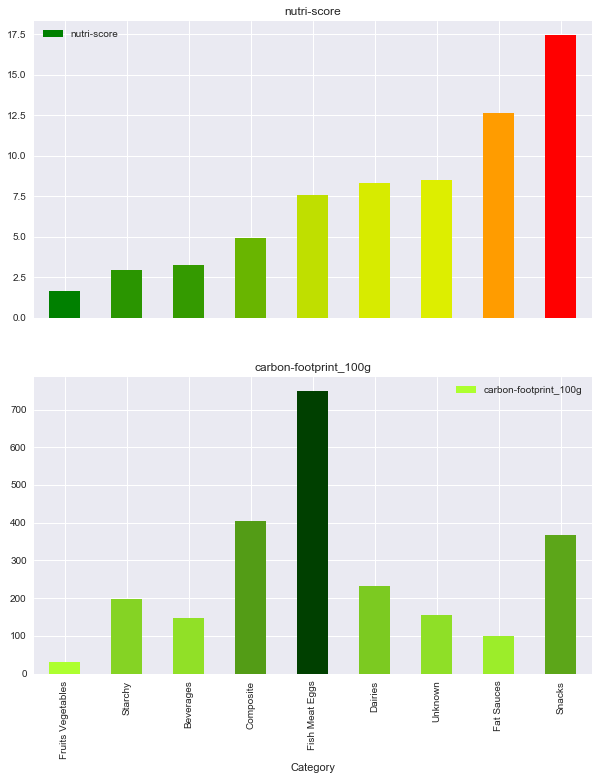

In [51]:
carbon_nutriscore_per_cat.plot.bar(subplots=True, figsize=(10, 12), color=[colors_nutri, colors_carbon]);

We observe some positive results for the fruits and vegetables as they have both a good nutritional score and a low carbon footprint. For the rest there doesn't seem to be any strong correlation, the `Fat Sauces` products also have a low carbon footprint even though its nutritional score is bad. We can notice the very high carbon footprint of the `Fish Meat Eggs` category, probably because meat and fish are often imported from other countries far away.

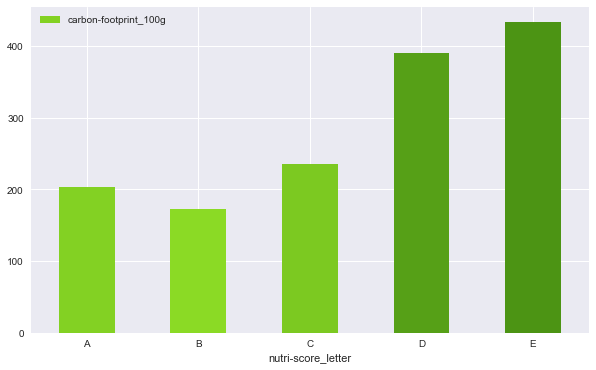

In [52]:
carbon_per_letter = data[['nutri-score_letter', 'carbon-footprint_100g']].groupby('nutri-score_letter').mean()
carbon_per_letter.plot.bar(rot=0, color=[[carbon_cm(carbon) for carbon in carbon_per_letter['carbon-footprint_100g']]], figsize=(10,6))

When we plot the carbon footprint mean per nutri-score letter, we clearly see some correlation: bad nutritional scores have a carbon footprint twice as high compared to the good ones.

### The recyclability of the product

In [53]:
pack_mapping = dict.fromkeys(['plastic', 'plastique,frais','plastique', 'barquette,plastique', 'sachet,plastique',
                              'frais,plastique','carton,plastique','carton,plastique,surgele','flacon,plastique'
                 'sachet-plastique','carton,boite,plastique', 'boite,plastique', 'plastique,carton','sachet-plastique',
                'sachet,plastique,surgele','barquette,plastique,frais','pot,plastique','plastique,sachet',
                             'plastico','boite,carton,plastique','frais,plastique,carton','frais,carton,plastique',
                              'carton,sachet,plastique','kunststoff','barquette,film,plastique,sous-atmosphere-protectrice',
                             'carton,surgele,plastique','plastique,barquette','sachet,plastique,frais',
                             'barquette,plastique,sous-atmosphere-protectrice','frais,barquette,plastique,opercule,film-plastique,sous-atmosphere-protectrice',
                             'sachet,plastique,carton','film,plastique','carton,plastique,frais','frais,pot,plastique','sachet,plastique,sous-atmosphere-protectrice',
                             'bolsa-de-plastico,ultracongelado','barquette-plastique','plastique,sous-vide','plastic,bag',
                             'barquette,film,plastique'],'Plastic')

pack_mapping.update(dict.fromkeys(['bouteille,verre','carton','boite,carton','carton,surgele','karton','carton,boite','karton,kunststoff',
                                  'sachet,papier','papier','bouteille,plastique','conserve','bocal,verre','glas',
                                  'bouteille','conserve,metal','bocal,verre,couvercle,metal','bocal,verre,metal',
                                  'verre','verre,bouteille','pot,verre','bocal','bolsa-de-plastico','verre,bocal',
                                  'flacon,plastique','bouteille-plastique','bottle','canned','pot-en-verre','bolsa,plastico',
                                   'bouteille-verre','bocal-en-verre','verre,bocal,metal','plastique,bouteille','bouteille-en-verre','canette','pot,verre,couvercle,metal',
                                  'glas,mehrwegpfand','carton,aluminium','boite,metal','botella-de-plastico','boite-carton',
                                  'plastic-bottle','sous-vide','plastic,bottle','can','pot-en-plastique'],'Recyclable'))

pack_mapping.update(dict.fromkeys(['frais','surgele','surgele,carton,plastique','brique,carton','tetra-pak','tetra-brik',
                                  'brique',],'Non-Recyclable'))

data['packaging_tags'].replace(pack_mapping, inplace=True)

In [88]:
main_packagings = ['Plastic', 'Recyclable', 'Non-Recyclable']

In [89]:
main_packagings_data = data.query('packaging_tags in @main_packagings')

In [126]:
nutri_pack = main_packagings_data.groupby(['nutri-score_letter', 'packaging_tags']).count()[['nutri-score']]\
             .reset_index().pivot(index='nutri-score_letter', columns='packaging_tags', values='nutri-score')
nutri_pack

packaging_tags,Non-Recyclable,Plastic,Recyclable
nutri-score_letter,,,
A,329,4557,3440
B,1094,3502,5677
C,733,4361,4445
D,587,13200,6786
E,49,6164,3216


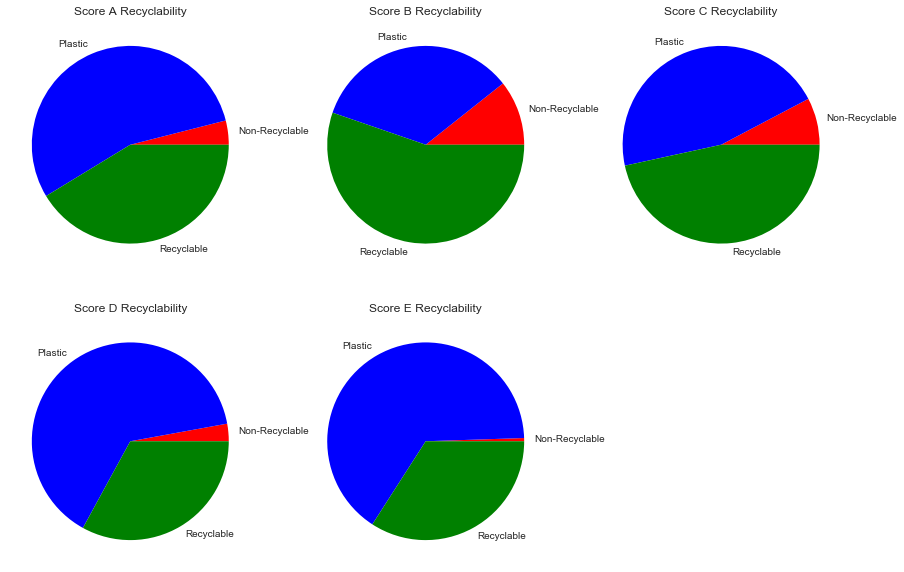

In [145]:
for idx, letter in enumerate(nutri_pack.index):
    ax = plt.subplot('23' + str(idx + 1))
    nutri_pack.loc[letter].plot.pie(ax=ax, title='Score {} Recyclability'.format(letter), colors=['red', 'blue', 'green'], figsize=(15,10))
    ax.set_ylabel('')

In [128]:
main_labels = ['Bio', 'Vegan', 'Green Dot', 'Vegetarian']
main_packagings_labels_data = main_packagings_data.query('labels_en in @main_labels')

In [129]:
labels_pack = main_packagings_labels_data.reset_index().groupby(['labels_en', 'packaging_tags']).count()[['index']]\
             .reset_index().pivot(index='labels_en', columns='packaging_tags', values='index')
labels_pack

packaging_tags,Non-Recyclable,Plastic,Recyclable
labels_en,,,
Bio,484,4534,5038
Green Dot,195,5921,3211
Vegan,110,440,431
Vegetarian,53,529,242


### Number of ingredients containing palm oil

Palm oil is an ingredient that is used in a lot of products (not only food). Its high usage is paired with a high need of ground for its cultivation. This leads to an immense amount of deforestation which is the source of multiple environmental problems. In order to protect the planet, one might want to reduce its consumption of palm oil, but how does it relate to the healthiness of the food? Let's investigate it.

In [57]:
nutri_palm = data[['nutri-score_letter', 'ingredients_from_palm_oil_n']].groupby('nutri-score_letter').mean()
may_nutri_palm = data[['nutri-score_letter', 'ingredients_that_may_be_from_palm_oil_n']].groupby('nutri-score_letter').mean()
nutri_palm_cm = cm.LinearColormap(['sienna','gold'], vmin=nutri_palm['ingredients_from_palm_oil_n'].min(), vmax=nutri_palm['ingredients_from_palm_oil_n'].max())

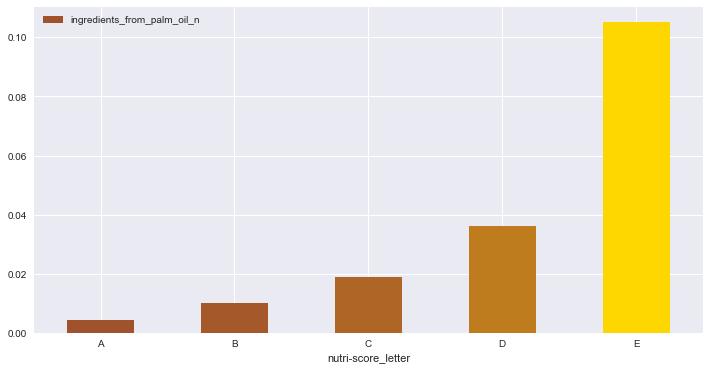

In [58]:
nutri_palm.plot.bar(rot=0, figsize = (12,6), color=[[nutri_palm_cm(palm) for palm in nutri_palm['ingredients_from_palm_oil_n']]]);

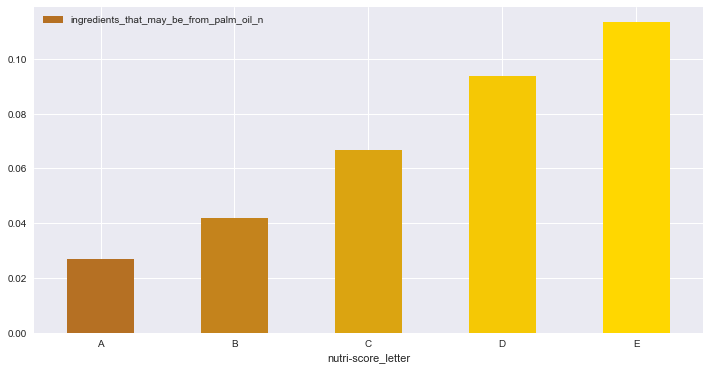

In [59]:
may_nutri_palm.plot.bar(rot=0, figsize = (12,6), color=[[nutri_palm_cm(palm) for palm in may_nutri_palm['ingredients_that_may_be_from_palm_oil_n']]]);

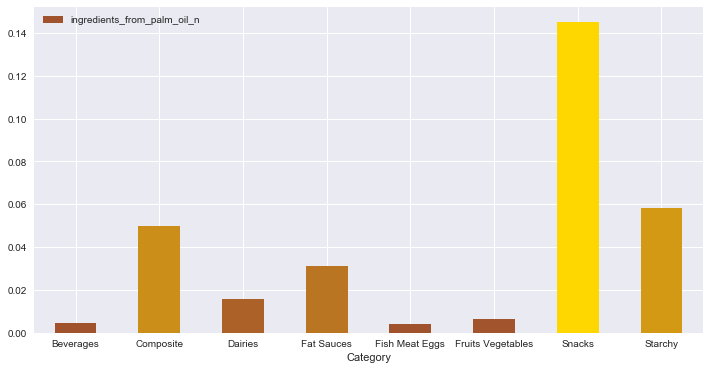

In [68]:
categ_palm = data[['Category', 'ingredients_from_palm_oil_n']].groupby('Category').mean().drop(index = 'Unknown')
categ_may_palm = data[['Category', 'ingredients_that_may_be_from_palm_oil_n']].groupby('Category').mean().drop(index = 'Unknown')

categ_palm.plot.bar(rot=0, figsize = (12,6), color=[[nutri_palm_cm(palm) for palm in categ_palm['ingredients_from_palm_oil_n']]]);

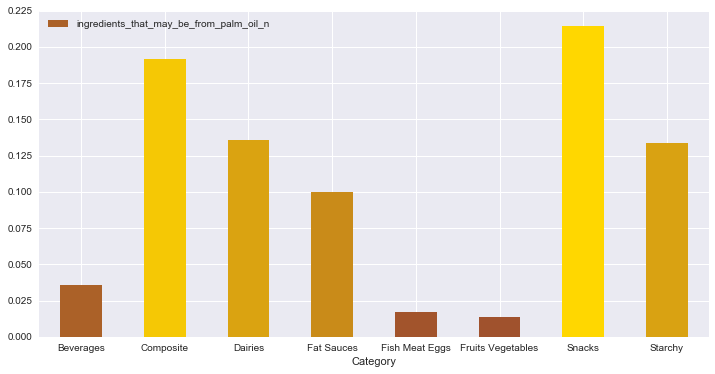

In [69]:
categ_palm_cm = cm.LinearColormap(['sienna','gold'], vmin=categ_palm['ingredients_from_palm_oil_n'].min(), vmax=categ_palm['ingredients_from_palm_oil_n'].max())
categ_may_palm_cm = cm.LinearColormap(['sienna','gold'], vmin=categ_may_palm['ingredients_that_may_be_from_palm_oil_n'].min(), vmax=categ_may_palm['ingredients_that_may_be_from_palm_oil_n'].max())
categ_may_palm.plot.bar(rot=0, figsize = (12,6), color=[[categ_may_palm_cm(palm) for palm in categ_may_palm['ingredients_that_may_be_from_palm_oil_n']]]);